# Matcha AI Platform
## Sales Forecasting All Drinks

In [3]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

## Dataset
Importing, viewing, and cleaning dataset.

In [4]:
# importing dataset
data_path = "../data/Online Retail.xlsx"
df = pd.read_excel(data_path)

In [5]:
# previewing dataset
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# filtering and cleaning data 

# dropping rows with missing values 
df = df.dropna(subset=['Description','InvoiceDate','Quantity'])

# filtering out negative quatitites (returns)
df = df[df['Quantity'] > 0]

# converting dates 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# creating a smaller dataset with only a few products (map to matcha drinks)
sample_products = [
    'WHITE HANGING HEART T-LIGHT HOLDER',  # map to "Iced Matcha Latte"
    'REGENCY CAKESTAND 3 TIER',            # map to "Strawberry Matcha"
    'JUMBO BAG RED RETROSPOT',             # map to "Classic Matcha Latte"
    'LUNCH BAG RED RETROSPOT',             # map to "Honey Lavender Matcha"
    'SET OF 3 CAKE TINS PANTRY DESIGN'     # map to "Matcha Lemonade"
]

df = df[df['Description'].isin(sample_products)]

# mapping product names to matcha drinks
drink_mapping = {
    'WHITE HANGING HEART T-LIGHT HOLDER': 'Iced Matcha Latte',
    'REGENCY CAKESTAND 3 TIER': 'Strawberry Matcha',
    'JUMBO BAG RED RETROSPOT': 'Classic Matcha Latte',
    'LUNCH BAG RED RETROSPOT': 'Honey Lavender Matcha',
    'SET OF 3 CAKE TINS PANTRY DESIGN': 'Matcha Lemonade'
}

df['Drink'] = df['Description'].map(drink_mapping)

## Data for time series 

In [27]:
# collecting data for time series

# grouping by date and drink
daily_sales = df.groupby(['InvoiceDate','Drink'])['Quantity'].sum().reset_index()

# pivot table : dates as rows, drinks as columns
pivot_sales = daily_sales.pivot(index='InvoiceDate', columns='Drink', values='Quantity').fillna(0)

# previewing 
pivot_sales.head()

Drink,Classic Matcha Latte,Honey Lavender Matcha,Iced Matcha Latte,Strawberry Matcha
InvoiceDate,,,,
2010-12-01 08:26:00,0.0,0.0,6.0,0.0
2010-12-01 09:02:00,0.0,0.0,6.0,0.0
2010-12-01 09:32:00,0.0,0.0,6.0,0.0
2010-12-01 09:37:00,0.0,10.0,0.0,0.0
2010-12-01 09:57:00,100.0,0.0,0.0,0.0


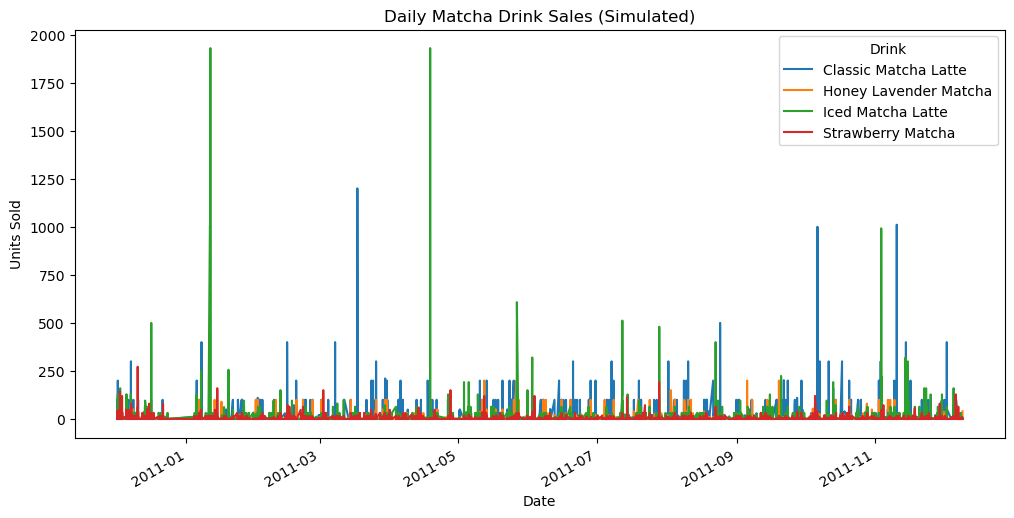

In [8]:
# visualizing total sales over time
pivot_sales.plot(figsize=(12, 6))
plt.title("Daily Matcha Drink Sales (Simulated)")
plt.ylabel("Units Sold")
plt.xlabel("Date")
plt.legend(title="Drink")
plt.show()

## Forecasting Each Drink

Forecasting for Iced Matcha Latte...


15:27:01 - cmdstanpy - INFO - Chain [1] start processing
15:27:02 - cmdstanpy - INFO - Chain [1] done processing


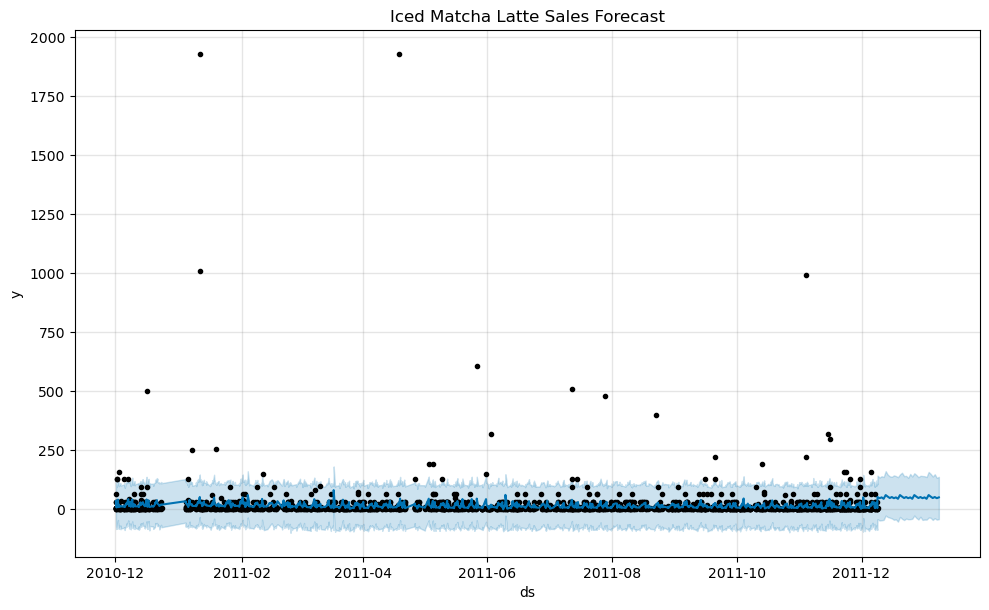

15:27:03 - cmdstanpy - INFO - Chain [1] start processing


Forecasting for Honey Lavender Matcha...


15:27:04 - cmdstanpy - INFO - Chain [1] done processing


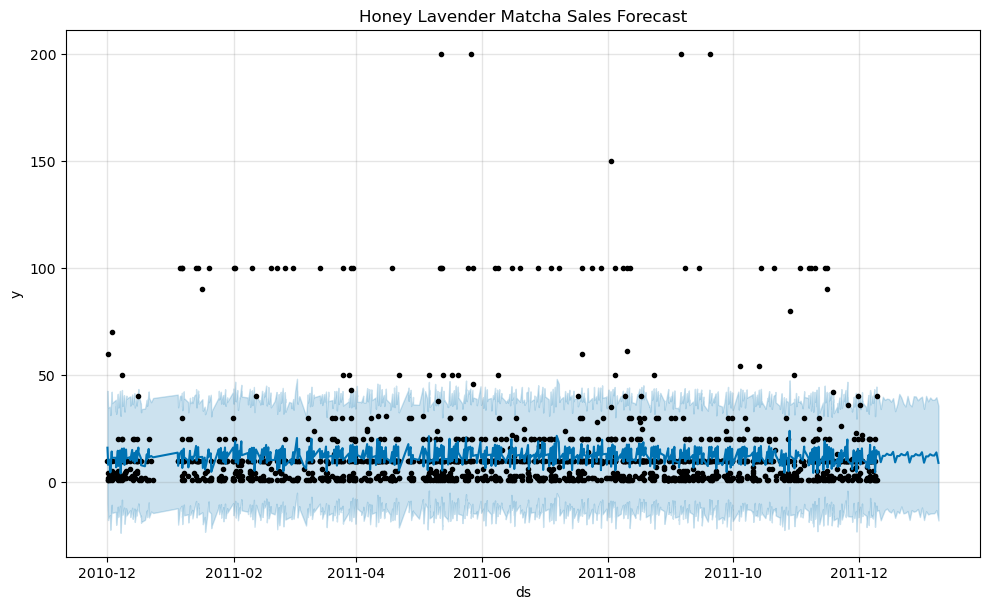

Forecasting for Classic Matcha Latte...


15:27:05 - cmdstanpy - INFO - Chain [1] start processing
15:27:05 - cmdstanpy - INFO - Chain [1] done processing


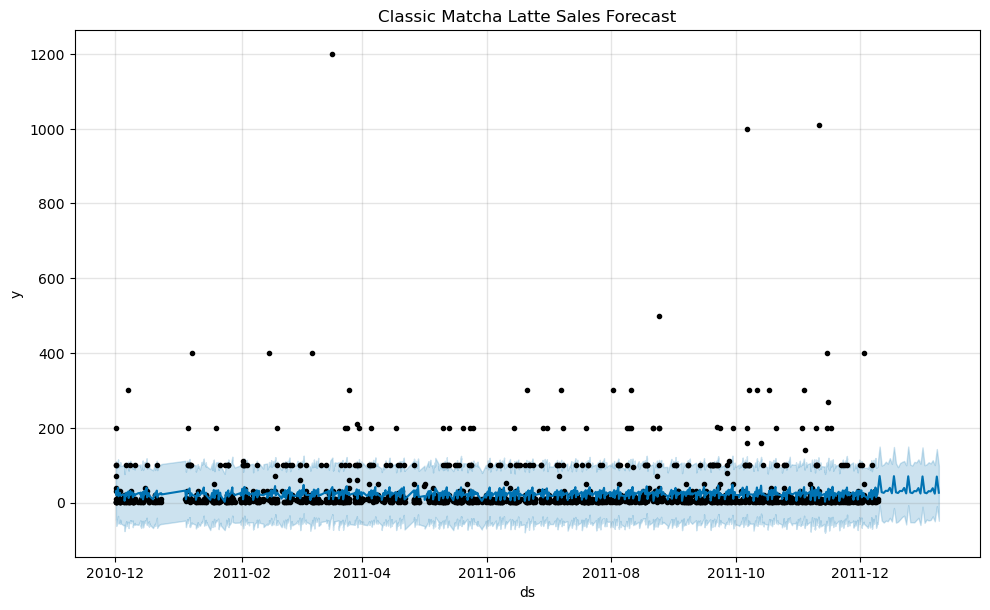

Forecasting for Strawberry Matcha...


15:27:07 - cmdstanpy - INFO - Chain [1] start processing
15:27:07 - cmdstanpy - INFO - Chain [1] done processing


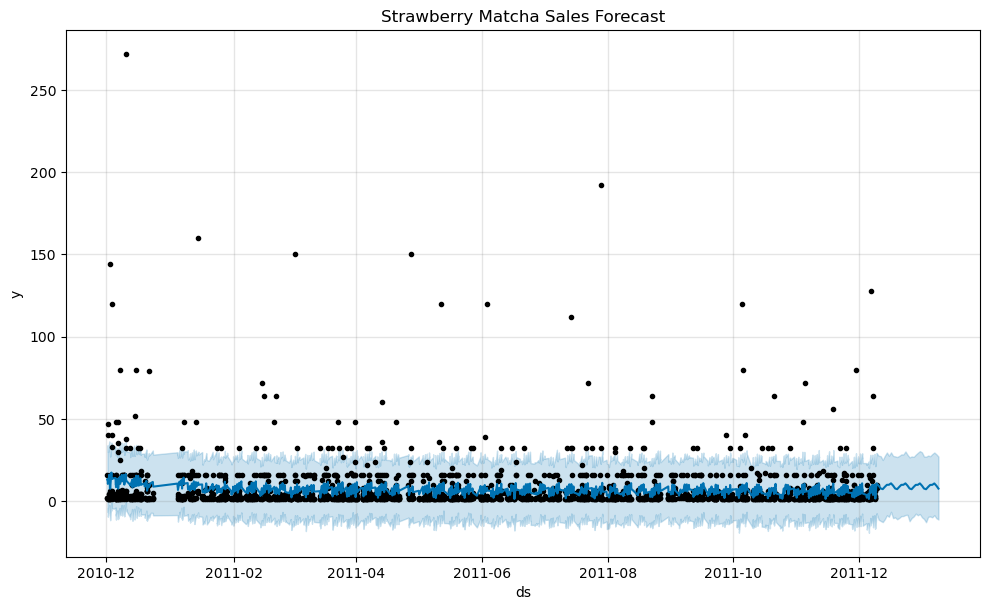

,ds,Drink,yhat,yhat_lower,yhat_upper
7898,2012-01-04 10:23:00,Strawberry Matcha,9.807239,-9.423576,27.268021
7899,2012-01-05 10:23:00,Strawberry Matcha,9.840273,-9.880123,28.544645
7900,2012-01-06 10:23:00,Strawberry Matcha,10.703187,-8.619919,29.529417
7901,2012-01-07 10:23:00,Strawberry Matcha,9.328184,-10.469774,28.436918
7902,2012-01-08 10:23:00,Strawberry Matcha,7.571094,-11.274179,27.047838


In [31]:
# forecasting each drink & storing them
forecast_results = pd.DataFrame()

# grouping by date and drink
daily_sales = df.groupby(['InvoiceDate','Drink'])['Quantity'].sum().reset_index()

# looping each drink
for drink in daily_sales['Drink'].unique():
    print(f"Forecasting for {drink}...")
    
    # filtering data for the current drink
    drink_data = daily_sales[daily_sales['Drink'] == drink][['InvoiceDate', 'Quantity']]
    drink_data = drink_data.rename(columns={'InvoiceDate': 'ds', 'Quantity': 'y'})
    
    # creating and fitting Prophet model
    model = Prophet()
    model.fit(drink_data)
    
    # creating future dates (next 30 days)
    future = model.make_future_dataframe(periods=30)
    
    # predict
    forecast = model.predict(future)
    forecast['Drink'] = drink  # Add drink name to forecast
    
    # combining into results dataframe
    forecast_results = pd.concat([forecast_results, forecast], ignore_index=True)
    
    # plotting individual forecast
    fig = model.plot(forecast)
    plt.title(f"{drink} Sales Forecast")
    plt.show()

# previewing combined forecast
forecast_results[['ds', 'Drink', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


In [32]:
# saving results to csv file 
forecast_results.to_csv("../data/forecast_results.csv", index=False)

integrate predictions into streamlit dashboard later